## We look at a stock market portfolio risk vs returns

Estimate future stock mean and variance based on historical price, with a weighting that decreases in historical time.

$$
\hat{r} = \frac{\sum_{t=1}^TW_tr_t}{\sum_{t=1}^TW_t}
$$

$$
\hat{\sigma}^2 = \frac{\sum_{t=1}^T(r_t - \hat{r})^2}{T-1}
$$

For example, if we count backwards in time, so $t=0$ is our newest stock price, we should do $W_t=\gamma^t$ for $\gamma<1$.

### Optimization Problem

So, given an estimate of the stock prices, variances, correlation and covariances, what is the optimal weightings for stocks to maximize returns while minimizing portfolio variances? So-called "diversification''.

Solve the quadratic programming problem:

$$
\min \frac{1}{2} \mathbf{w}^T \Sigma \mathbf{w} \quad \text{(portfolio variance)}
$$
$$
\text{s.t. } \mathbf{m}^T \mathbf{w} \geq \mu_B \quad \text{(portfolio return }\geq \mu_b)
$$
$$
\& \quad \mathbf{w} \in \Delta_{N} \quad \text{w is a simplex -- pdf}
$$

Where $w$ is our weightings for each stock (proportions), $\Sigma$ is the matrix of their covariances, $\mathbf{m}$ is a vector of the estimated mean asset prices. $\mu_B$ is your desired profits, so it can be extremized too, at the cost of more variance.

We will minimize his using SLSQP in scipy.optimize, which is used for problems of this form.

### Efficient Frontier

The distribution of all portfolio weightings, when mapped to the point $(\mu_B, w\Sigma w )$, will have a boundary. We can construct a convex hull and use MC sampling to get a good estimate of the best portfolios.

In [1]:
import numpy as np
import random, copy
import datetime as dt
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yfin
import scipy.optimize as optimize
import matplotlib.pyplot as plt
yfin.pdr_override()

### Parameters

In [5]:
from MPT import *

# for visualizing returns on portfolio, we can put our invested cash price here. It's a fun exercise.
cash = 100000

stock_list = ['GOOG', 'AAPL', 'ETSY', 'META', 'GOOGL', 'TSLA', 'TECL', 'POET', 'ABBV', 'TAP', 'NVDA', 'AMD', 'MSI', 'CLX', 'NEE', 'DG', 'DHR', 'AMZN', 'VRTX', 'CHE', 'JNJ', 'JKHY', 'SHW', ]


# end of data, and time delta to look back into the past
end = dt.datetime(2022, 10, 15)
start = end - dt.timedelta(days = 1200)

means, covariances = get_data(stock_list, start, end, decay_tau = 800)

[*********************100%%**********************]  23 of 23 completed


### Max Sharp Ratio (SNR) Portfolio

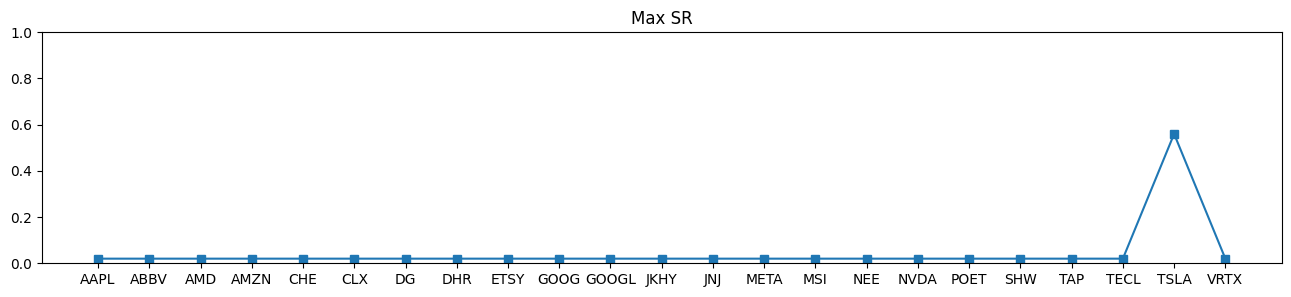

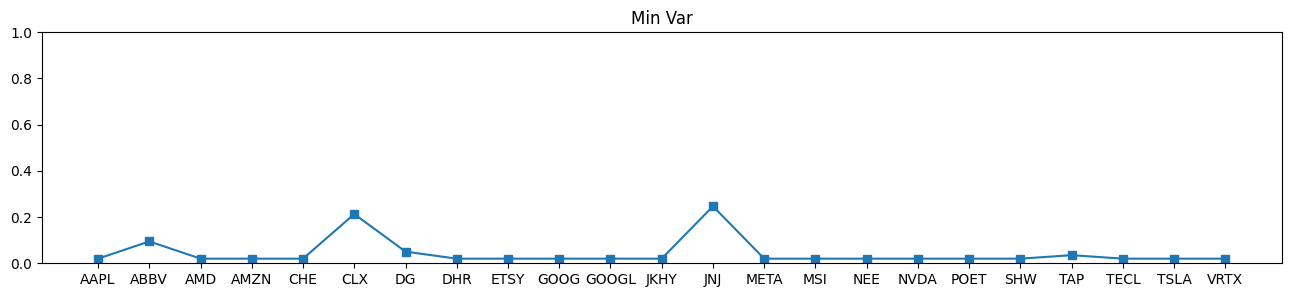

In [6]:
# notice how we can specify the weight range, which allows us to have a minimum weight value for all stocks
maxSR_dataframe, minvar_dataframe, efficient_weights, efficient_front = get_all_results(means, covariances, riskfreerate=0.05, weight_range=(1/50, 1.0), N_steps=50)

plt.figure(figsize=[16,3])
plt.title('Max SR')
plt.plot(maxSR_dataframe, marker = 's')
plt.ylim(0,1)
plt.show() 
plt.figure(figsize=[16,3])
plt.title('Min Var')
plt.plot(minvar_dataframe, marker = 's')
plt.ylim(0,1)
plt.show() 

### Monte Carlo

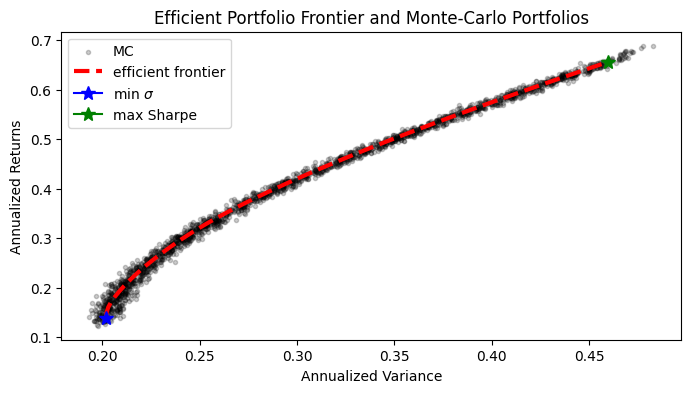

In [7]:
# here we use monte carlo sampling to slightly change portfolios on the efficient frontier 
# we can see how risk/returns vary from small perturbations to the weightings
p_ret_var = MC_portfolios(2000, means, covariances, efficient_weights, epsilon = 0.007)

plt.figure(figsize = [8,4])
plt.scatter(p_ret_var[1], p_ret_var[0], marker = '.', alpha = 0.2, color = 'black', label = 'MC')
plt.plot(efficient_front[1], efficient_front[0], color = 'red', linestyle = '--', linewidth = 3, label = 'efficient frontier')
plt.plot(efficient_front[1, 0], efficient_front[0, 0], marker = '*', alpha = 1, color = 'blue', markersize = 10, label = r'min $\sigma$')
plt.plot(efficient_front[1, -1], efficient_front[0, -1], marker = '*', alpha = 1, color = 'green', markersize = 10, label = r'max Sharpe')
plt.title(r'Efficient Portfolio Frontier and Monte-Carlo Portfolios')
plt.xlabel(r'Annualized Variance')
plt.ylabel(r'Annualized Returns')
plt.legend()
plt.show()

### Analyzing performance

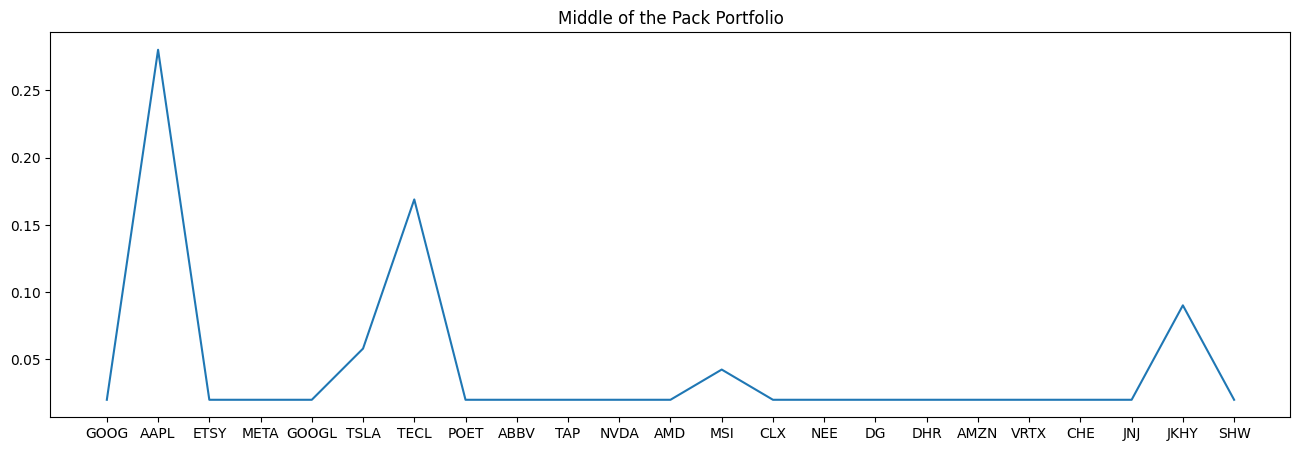

Middle of the Pack Portfolio
GOOG  $ 2000.0
AAPL  $ 28026.098
ETSY  $ 2000.0
META  $ 2000.0
GOOGL  $ 2000.0
TSLA  $ 5807.032
TECL  $ 16897.015
POET  $ 2000.0
ABBV  $ 2000.0
TAP  $ 2000.0
NVDA  $ 2000.0
AMD  $ 2000.0
MSI  $ 4246.891
CLX  $ 2000.0
NEE  $ 2000.0
DG  $ 2000.0
DHR  $ 2000.0
AMZN  $ 2000.0
VRTX  $ 2000.0
CHE  $ 2000.0
JNJ  $ 2000.0
JKHY  $ 9022.964
SHW  $ 2000.0
[*********************100%%**********************]  23 of 23 completed


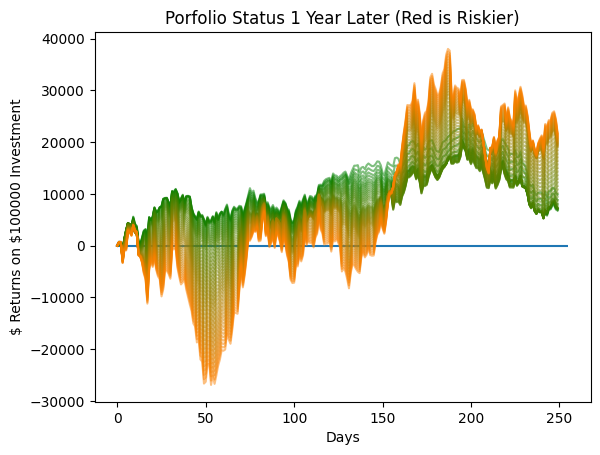

In [8]:
# a middle of the pack portfolio from our frontier

# calculate the returns of the year after our porfolio is implemented
#end = dt.datetime.now()
start_year_after = end 
end_year_after = start_year_after + dt.timedelta(days = 365)

mop_weights = efficient_weights[round(len(stock_list)/2)]

plt.figure(figsize=[16,5])
plt.title('Middle of the Pack Portfolio')
plt.plot(mop_weights)
plt.xticks(np.arange(0, len(stock_list)), labels=stock_list)
plt.show()


print('Middle of the Pack Portfolio')
for i, stock in enumerate(stock_list):
    print(stock, ' $', round(mop_weights[i] * cash, ndigits=3))

stock_data = pdr.get_data_yahoo(stock_list, start = start_year_after, end = end_year_after)['Close']

stock_data = stock_data.to_numpy()


plt.figure()
plt.hlines(0, 0, 255)
# profit for each stock
deltas = stock_data/stock_data[0]

for i, weight in enumerate(efficient_weights):

    profits = []

    for j in range(deltas.shape[0]):
        profits.append(weight.dot(deltas[j]))

    r = i / 50
    plt.plot((np.array(profits) - 1)*cash, color=(r, 0.5, 0), alpha = 0.5)


plt.ylabel('\$ Returns on \$%d Investment' % cash)
plt.xlabel('Days')

plt.title('Porfolio Status 1 Year Later (Red is Riskier)')
plt.show()